In [1]:
# Imports
import os
import pickle
import pandas as pd
from datetime import datetime
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline

In [2]:
#Constants and Vars
TC_CSX = {'hp': 158, 'torque': 139, 'mass':1313}
TC = TC_CSX
hpmratio = TC['hp'] / TC['mass']
tmratio = TC['torque'] / TC['mass']


DATA_FILE = '34'
DATA_FILES = [26,27,28,31,32,33,34,36,37,38,40]
DATA_FOLDER = 'hwd_data2'
FILE_NAME = "{}/run_{}.csv".format(DATA_FOLDER, DATA_FILE)
FILE_NAMES = ["{}/run_{}.csv".format(DATA_FOLDER, f) for f in DATA_FILES]
SAVE_FOLDER = 'hwd_processed'
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [3]:
with open('models/hwy_classifier.p', 'rb') as handle:
    hwy_classifier = pickle.load(handle)


In [4]:
hwy_classifier.predict([[71,0.2,0.2]])[0]

0

In [5]:
def format_df(f_names):
    df = pd.concat((pd.read_csv(f,header=None,sep=',', names=['date', 'speed', 'engine_load','throttle','rpm',
                                                      'heading', 'roll', 'pitch',
                                                      'sys', 'gyro', 'accel', 'mag',
                                                      'magx', 'magy', 'magz',
                                                      'gyrx', 'gyry', 'gyrz',
                                                      'linaccx', 'linaccy', 'linaxxz'
                                                     ]) for f in f_names))
    df['time'] = (df.date - df.date.iloc[0])
    df['time_diff'] = df.time.diff()
    df['speed'] = df.speed.str.replace(' kph','')
    df['engine_load'] = df.engine_load.str.replace(' percent', '')
    df['throttle'] = df.throttle.str.replace(' percent', '')
    df['rpm'] = df.rpm.str.replace(' revolutions_per_minute', '')

    obd2_cols = ['speed', 'engine_load', 'throttle', 'rpm']
    for col in obd2_cols:
        df[col].replace('None', np.nan,inplace=True)
        df[col] = df[col].apply(np.float64)
        df[col] = df[col].interpolate(limit=4,direction='both')
    df = df[1:-1]

    min_throttle = df.throttle.min()
    df['throttle'] = df['throttle'] * (1+0.01*min_throttle) - min_throttle
    df = df[df.speed > 0]

    df['lateral_velocity'] = df.heading.diff() / df.time_diff
    df['speed_diff'] = df.speed.diff()
    df['acc'] = df.speed_diff / df.time_diff
    return df

def calculate_score(score, averaged_score, max_score):
    
    final_score = 0

    if score > averaged_score:
        calculate_difference= (score - averaged_score)/(max_score - averaged_score)
        final_score = 2.5 + 2.5 * calculate_difference
    else:
        final_score = (score/averaged_score * 2.5)
            
    return final_score

In [9]:
test_df = format_df(FILE_NAMES)

In [13]:

class flModel:
    def format_df(f_names):
        df = pd.concat((pd.read_csv(f,header=None,sep=',', names=['date', 'speed', 'engine_load','throttle','rpm',
                                                          'heading', 'roll', 'pitch',
                                                          'sys', 'gyro', 'accel', 'mag',
                                                          'magx', 'magy', 'magz',
                                                          'gyrx', 'gyry', 'gyrz',
                                                          'linaccx', 'linaccy', 'linaxxz'
                                                         ]) for f in f_names))
        df['time'] = (df.date - df.date.iloc[0])
        df['time_diff'] = df.time.diff()
        df['speed'] = df.speed.str.replace(' kph','')
        df['engine_load'] = df.engine_load.str.replace(' percent', '')
        df['throttle'] = df.throttle.str.replace(' percent', '')
        df['rpm'] = df.rpm.str.replace(' revolutions_per_minute', '')

        obd2_cols = ['speed', 'engine_load', 'throttle', 'rpm']
        for col in obd2_cols:
            df[col].replace('None', np.nan,inplace=True)
            df[col] = df[col].apply(np.float64)
            df[col] = df[col].interpolate(limit=4,direction='both')
        df = df[1:-1]

        min_throttle = df.throttle.min()
        df['throttle'] = df['throttle'] * (1+0.01*min_throttle) - min_throttle
        df = df[df.speed > 0]

        df['lateral_velocity'] = df.heading.diff() / df.time_diff
        df['speed_diff'] = df.speed.diff()
        df['acc'] = df.speed_diff / df.time_diff
        return df
        
    def _init_hp(self, data_df):
        average_rpm = data_df['rpm'].median()
        max_rpm = data_df['rpm'].max()
        min_rpm = data_df['rpm'].min()

        rpm = np.arange(0, max_rpm + 1, 1)
        rpm_set = ctrl.Antecedent(rpm, 'rpm')

        # Generate fuzzy membership functions
        rpm_lo = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
        rpm_md = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
        rpm_hi = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

        rpm_set['L'] = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
        rpm_set['M'] = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
        rpm_set['H'] = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

        fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

        ax0.plot(rpm, rpm_lo, 'b', linewidth=1.5, label='L')
        ax0.plot(rpm, rpm_md, 'g', linewidth=1.5, label='M')
        ax0.plot(rpm, rpm_hi, 'r', linewidth=1.5, label='H')
        ax0.set_title('Vehicle RPM')
        ax0.legend()

        data_df['acc'] = data_df.speed_diff / data_df.time_diff

        acc_df = data_df[data_df.acc >0]

        average_acc = acc_df['acc'].median()
        max_acc = acc_df['acc'].max()
        min_acc = acc_df['acc'].min()

    #     print(acc_df['acc'].mean(), acc_df['acc'].median(), min_acc, max_acc)

        acc = np.arange(0, max_acc + 0.1, 0.1)

        acc_set = ctrl.Antecedent(acc, 'acc')

        # Generate fuzzy membership functions
        acc_lo = fuzz.trimf(acc, [0, min_acc, average_acc])
        acc_md = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
        acc_hi = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

        acc_set['L'] = fuzz.trimf(acc, [0, min_acc, average_acc])
        acc_set['M'] = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
        acc_set['H'] = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

        ax1.plot(acc, acc_lo, 'b', linewidth=1.5, label='L')
        ax1.plot(acc, acc_md, 'g', linewidth=1.5, label='M')
        ax1.plot(acc, acc_hi, 'r', linewidth=1.5, label='H')
        ax1.set_title('Vehicle Acceleration')
        ax1.legend()

        HP = np.arange(0, 5.1, 0.1)

        HP_lo = fuzz.trimf(HP, [0, 1, 2.5])
        HP_md = fuzz.trimf(HP, [1.5, 2.5, 3.5])
        HP_hi = fuzz.trimf(HP, [2.5, 5, 5])

        HP_set = ctrl.Consequent(HP, 'HP')

        HP_set['L'] = fuzz.trimf(HP, [0, 1, 2.5])
        HP_set['M'] = fuzz.trimf(HP, [1.5, 2.5, 3.5])
        HP_set['H'] = fuzz.trimf(HP, [2.5, 5, 5])

        ax2.plot(HP, HP_lo, 'b', linewidth=1.5, label='L')
        ax2.plot(HP, HP_md, 'g', linewidth=1.5, label='M')
        ax2.plot(HP, HP_hi, 'r', linewidth=1.5, label='H')
        ax2.set_title('Vehicle Horsepower')
        ax2.legend()


        rule1 = ctrl.Rule(acc_set['L'] & rpm_set['L'], HP_set['L'])
        rule2 = ctrl.Rule(acc_set['L'] & rpm_set['M'], HP_set['M'])
        rule3 = ctrl.Rule(acc_set['L'] & rpm_set['H'], HP_set['H'])

        rule4 = ctrl.Rule(acc_set['M'] & rpm_set['L'], HP_set['L'])
        rule5 = ctrl.Rule(acc_set['M'] & rpm_set['M'], HP_set['H'])
        rule6 = ctrl.Rule(acc_set['M'] & rpm_set['H'], HP_set['H'])

        rule7 = ctrl.Rule(acc_set['H'] & rpm_set['L'], HP_set['L'])
        rule8 = ctrl.Rule(acc_set['H'] & rpm_set['M'], HP_set['H'])
        rule9 = ctrl.Rule(acc_set['H'] & rpm_set['H'], HP_set['H'])

        system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
        self.hp_simulator = ctrl.ControlSystemSimulation(system)

    def _init_aggression(self):
        x_velocity = np.arange(0, 100.1, 0.1)
        x_throttle = np.arange(0, 1.01, 0.01)
        x_aggressiveness  = np.arange(-4, 5, 1)

        # Generate fuzzy membership functions
        vel_lo = fuzz.trimf(x_velocity, [0, 0, 40])
        vel_md = fuzz.trimf(x_velocity, [15, 50, 85])
        vel_hi = fuzz.trimf(x_velocity, [60, 100, 100])
        throttle_lo = fuzz.trimf(x_throttle, [0, 0, 0.4])
        throttle_md = fuzz.trimf(x_throttle, [0.2, 0.5, 0.8])
        throttle_hi = fuzz.trimf(x_throttle, [0.6, 1.0, 1.0])
        aggressive_LN = fuzz.trimf(x_aggressiveness, [-4, -4, -2])
        aggressive_N = fuzz.trimf(x_aggressiveness, [-3, -2, -1])
        aggressive_M = fuzz.trimf(x_aggressiveness, [-2, 0, 2 ])
        aggressive_A = fuzz.trimf(x_aggressiveness, [1, 2, 3])
        aggressive_HA = fuzz.trimf(x_aggressiveness, [2, 3, 4])
        velocity = ctrl.Antecedent(x_velocity, 'velocity')
        throttle = ctrl.Antecedent(x_throttle, 'throttle')
        aggressiveness = ctrl.Consequent(x_aggressiveness, 'aggressiveness')
        velocity.automf(names=['L', 'M', 'H'])
        throttle.automf(names=['L', 'M', 'H'])
        aggressiveness.automf(names=['LN', 'N', 'M', 'A', 'HA'])

        rule1 = ctrl.Rule(velocity['L'] & throttle['L'], aggressiveness['LN'])
        rule2 = ctrl.Rule(velocity['L'] & throttle['M'], aggressiveness['M'])
        rule3 = ctrl.Rule(velocity['L'] & throttle['H'], aggressiveness['HA'])
        rule4 = ctrl.Rule(velocity['M'] & throttle['L'], aggressiveness['N'])
        rule5 = ctrl.Rule(velocity['M'] & throttle['M'], aggressiveness['M'])
        rule6 = ctrl.Rule(velocity['M'] & throttle['H'], aggressiveness['A'])
        rule7 = ctrl.Rule(velocity['H'] & throttle['L'], aggressiveness['HA'])
        rule8 = ctrl.Rule(velocity['H'] & throttle['M'], aggressiveness['A'])
        rule9 = ctrl.Rule(velocity['H'] & throttle['H'], aggressiveness['HA'])

        system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
        self.agg_simulator = ctrl.ControlSystemSimulation(system)
        
    def _init_torque(self):
        x_velocity = np.arange(0, 100.1, 0.1)
        x_throttle = np.arange(0, 1.01, 0.01)
        x_torque  = np.arange(0, 5.1, 0.1)

        # Generate fuzzy membership functions

        torque_L = fuzz.trimf(x_torque, [0, 0, 2.5])
        torque_M = fuzz.trimf(x_torque, [0, 2.5, 5])
        torque_A = fuzz.trimf(x_torque, [2.5, 5, 5])
        velocity = ctrl.Antecedent(x_velocity, 'velocity')
        throttle = ctrl.Antecedent(x_throttle, 'throttle')
        torque_set = ctrl.Consequent(x_torque, 'torque')
        torque_set['L'] = fuzz.trimf(x_torque, [0, 1, 2.5])
        torque_set['M'] = fuzz.trimf(x_torque, [1.5, 2.5, 3.5])
        torque_set['H'] = fuzz.trimf(x_torque, [2.5, 5, 5])
        velocity['L'] = fuzz.trimf(x_velocity, [0, 0, 40])
        velocity['M'] = fuzz.trimf(x_velocity, [15, 50, 85])
        velocity['H'] = fuzz.trimf(x_velocity, [60, 100, 100])
        throttle['L'] = fuzz.trimf(x_throttle, [0, 0, 0.4])
        throttle['M'] = fuzz.trimf(x_throttle, [0.2, 0.5, 0.8])
        throttle['H'] = fuzz.trimf(x_throttle, [0.6, 1.0, 1.0])
        # velocity.automf(names=['L', 'M', 'H'])
        # throttle.automf(names=['L', 'M', 'H'])
        # aggressiveness.automf(names=['L', 'M', 'H'])

        rule1 = ctrl.Rule(velocity['L'] & throttle['L'], torque_set['L'])
        rule2 = ctrl.Rule(velocity['L'] & throttle['M'], torque_set['M'])
        rule3 = ctrl.Rule(velocity['L'] & throttle['H'], torque_set['H'])
        rule4 = ctrl.Rule(velocity['M'] & throttle['L'], torque_set['L'])
        rule5 = ctrl.Rule(velocity['M'] & throttle['M'], torque_set['M'])
        rule6 = ctrl.Rule(velocity['M'] & throttle['H'], torque_set['H'])
        rule7 = ctrl.Rule(velocity['H'] & throttle['L'], torque_set['L'])
        rule8 = ctrl.Rule(velocity['H'] & throttle['M'], torque_set['M'])
        rule9 = ctrl.Rule(velocity['H'] & throttle['H'], torque_set['H'])

        system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
        self.torque_simulator = ctrl.ControlSystemSimulation(system)
        
    def compute_torque(self, velocity, throttle):
        self.torque_simulator.input['velocity'] = velocity
        self.torque_simulator.input['throttle'] = throttle
        self.torque_simulator.compute()
        return self.torque_simulator.output['torque']

    def count_braking_steps(self, data_df):
        counter = 0 
        previous_acceleration = 0
        acceleration = 0
        #this variable is for when they start deacceleration (We record when acceleration goes to deacceleration)
        num_of_times_brake_average = 0
        num_of_times_stepped = 0
        acceleration_diff = 0
        error_margin = 1
        previous_acceleration_diff = 0
        for index, row in data_df.iterrows():

            curr_acceleration = row['acc']

            if counter == 0:
                previous_acceleration = curr_acceleration
            else:

                if previous_acceleration > 0 and curr_acceleration < 0:
                    num_of_times_brake_average += 1
                    num_of_times_stepped += 1

                difference = curr_acceleration - previous_acceleration

                if previous_acceleration_diff < 0 and difference < 0 and difference < (previous_acceleration_diff - error_margin): 
                    num_of_times_stepped += 1

                if curr_acceleration < 0 and previous_acceleration < 0:
                    previous_acceleration_diff = curr_acceleration - previous_acceleration
                else: 
                    previous_acceleration_diff = 0

            previous_acceleration = curr_acceleration
            counter = counter + 1

        return (num_of_times_brake_average, num_of_times_stepped)
    
    def _init_braking(self, data_df):

        data_df['deacc'] = -1 * data_df['acc'] 
        #Invert values so they confuse less 

        #Determine number of times

        num_of_times_brake_average, num_of_times_stepped = self.count_braking_steps(data_df)
        data_df = data_df.query('deacc > 1')
        
        
        average_deacc = data_df['deacc'].mean()
        max_deacc = data_df['deacc'].max()
        min_deacc = data_df['deacc'].min()

        deacc = np.arange(0, max_deacc + 0.1, 0.1)
        deacc_set = ctrl.Antecedent(deacc, 'deacc')
        deacc_set['L'] = fuzz.trimf(deacc, [0, min_deacc, average_deacc])
        deacc_set['M'] = fuzz.trimf(deacc, [0.6 * average_deacc, average_deacc, average_deacc * 1.3])
        deacc_set['H'] = fuzz.trimf(deacc, [average_deacc, max_deacc, max_deacc])
        
        num_of_times_brake_average = num_of_times_brake_average/11.0
        
        braking_steps = np.arange(0, num_of_times_brake_average * 2 + 0.1, 0.1)
        braking_steps_set = ctrl.Antecedent(braking_steps, 'braking_steps')
        braking_steps_set['L'] = fuzz.trimf(braking_steps, [0, num_of_times_brake_average * 0.8, num_of_times_brake_average])
        braking_steps_set['M'] = fuzz.trimf(braking_steps, [0.75 * num_of_times_brake_average, num_of_times_brake_average, num_of_times_brake_average * 1.75])
        braking_steps_set['H'] = fuzz.trimf(braking_steps, [num_of_times_brake_average * 1.25, num_of_times_brake_average * 2, num_of_times_brake_average * 2])

    
        braking_quality = np.arange(0, 5.1, 0.1)

        braking_quality_set = ctrl.Consequent(braking_quality, 'braking_quality')

        braking_quality_set['L'] = fuzz.trimf(braking_quality, [0, 1, 2.5])
        braking_quality_set['M'] = fuzz.trimf(braking_quality, [1.5, 2.5, 3.5])
        braking_quality_set['H'] = fuzz.trimf(braking_quality, [2.5, 5, 5])

        braking_quality_set.view()

        rule1 = ctrl.Rule(deacc_set['L'] & braking_steps_set['L'], braking_quality_set['H'])
        rule2 = ctrl.Rule(deacc_set['L'] & braking_steps_set['M'], braking_quality_set['M'])
        rule3 = ctrl.Rule(deacc_set['L'] & braking_steps_set['H'], braking_quality_set['L'])

        rule4 = ctrl.Rule(deacc_set['M'] & braking_steps_set['L'], braking_quality_set['H'])
        rule5 = ctrl.Rule(deacc_set['M'] & braking_steps_set['M'], braking_quality_set['M'])
        rule6 = ctrl.Rule(deacc_set['M'] & braking_steps_set['H'], braking_quality_set['L'])

        rule7 = ctrl.Rule(deacc_set['H'] & braking_steps_set['L'], braking_quality_set['H'])
        rule8 = ctrl.Rule(deacc_set['H'] & braking_steps_set['M'], braking_quality_set['H'])
        rule9 = ctrl.Rule(deacc_set['H'] & braking_steps_set['H'], braking_quality_set['L'])


        system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

        self.brake_simulator =  ctrl.ControlSystemSimulation(system)

    def compute_brake(self, deacc_average, num_brakes):
        self.brake_simulator.input['deacc'] = deacc_average
        self.brake_simulator.input['braking_steps'] = num_brakes 

        self.brake_simulator.compute()
        return self.brake_simulator.output['braking_quality']
        
    def compute_agg(self, velocity_input, throttle_input):
        self.agg_simulator.input['velocity'] = velocity_input
        self.agg_simulator.input['throttle'] = throttle_input
        self.agg_simulator.compute()
        return self.agg_simulator.output['aggressiveness']
    
    def compute_hp(self, acc_input, rpm_input):
        self.hp_simulator.input['acc'] = acc_input
        self.hp_simulator.input['rpm'] = rpm_input
        self.hp_simulator.compute()
        return self.hp_simulator.output['HP']
    
    def __init__(self, data_df):
        self._init_aggression()
        self._init_hp(data_df)
        self._init_braking(data_df)
        self._init_torque()
        self.average_lateral_overall = data_df['lateral_velocity'].apply(abs).mean()
        self.max_lateral = data_df['lateral_velocity'].apply(abs).max()
        
    
    def calculate_score(self, score, averaged_score, max_score):

        final_score = 0

        if score > averaged_score:
            calculate_difference= (score - averaged_score)/(max_score - averaged_score)
            final_score = 2.5 + 2.5 * calculate_difference
        else:
            final_score = (score/averaged_score * 2.5)

        return final_score
        

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


3.7630341816559292

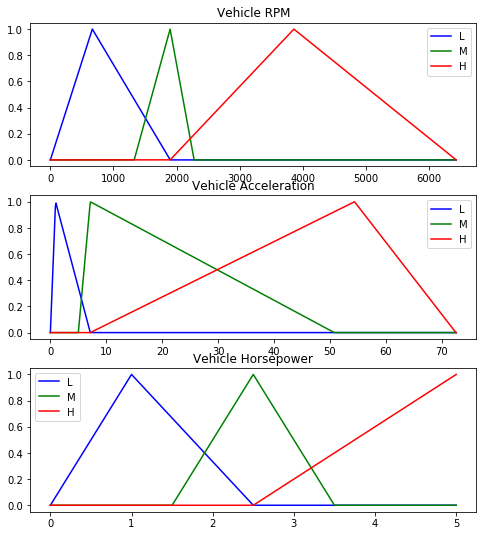

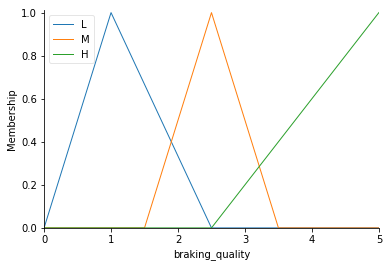

In [11]:
m = flModel(test_df)
m.compute_brake(1, 1)

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


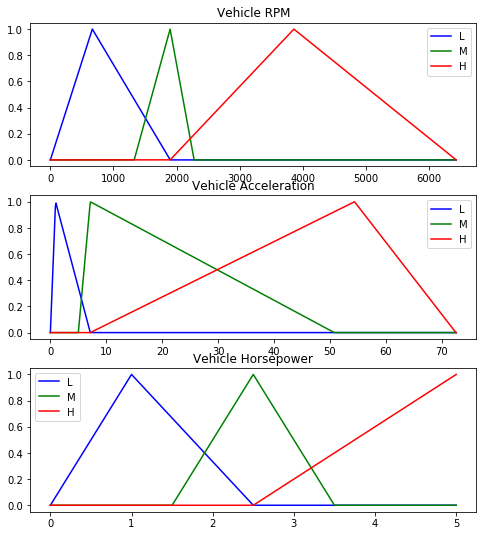

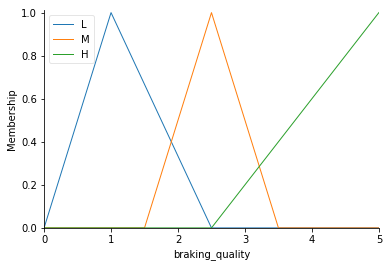

In [14]:
m = flModel(test_df)
with open('models/fuzzy_models.p', 'wb') as handle:
    pickle.dump(m, handle, protocol=3)

In [ ]:
run_df = format_df([FILE_NAME])

num_of_brakes_average, num_of_brakes_stepped = m.count_braking_steps(run_df)

average_acc = run_df[run_df['acc'] > 0]['acc'].mean()
average_rpm = run_df['rpm'].mean()
average_vel = run_df['speed'].mean()
average_throttle = run_df['throttle'].mean()
average_lateral = run_df['lateral_velocity'].apply(abs).mean()


run_df['deacc'] = -1 * run_df['acc'] 
run_df = run_df.query('deacc > 1')

average_deacc = run_df['deacc'].mean()

brake_score = m.compute_brake(average_deacc, num_of_brakes_stepped)
hp_score = m.compute_hp(average_acc, average_rpm)
torque_score = m.compute_torque(average_vel, average_throttle)
lateral_score = m.calculate_score(average_lateral, m.average_lateral_overall, m.max_lateral)